# EE4211 Data Science for IoT: Project

## Team Number: 23

Team Members:
1. Tan Kai Xin, Nicole
2. Erik Naeslund
3. Peng Ziwei

## ExampleAPI

Example API to extract LTA Datamall Capark Availability Data

In [1]:
import requests
import json
import pandas as pd

# Change these values for different dates
year = "2024"
month = "7"
day = "12"
hour = "12"
minute = "25"
second = "0"

site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
print(site)
response_API = requests.get(site)
data = response_API.text
data = json.loads(data)
timestamp = data["items"][0]["timestamp"]
print(timestamp)

data = data["items"][0]["carpark_data"]
with open("EE4211data.json", 'w') as fp:
    json.dump(data, fp)
df = pd.read_json("EE4211data.json")
for heading in ("total_lots","lot_type","lots_available"):
    df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
df = df.drop(["carpark_info"], axis=1)
display(df)

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-12T12%3A25%3A00
2024-07-12T12:24:27+08:00


,carpark_number,update_datetime,total_lots,lot_type,lots_available
0,HE12,2024-07-12T12:23:44,105,C,27
1,HLM,2024-07-12T12:23:53,583,C,25
2,RHM,2024-07-12T12:23:44,329,C,130
3,BM29,2024-07-12T12:23:49,97,C,0
4,Q81,2024-07-12T12:23:37,97,C,0
...,...,...,...,...,...
1973,BA7,2024-07-12T12:23:47,261,C,163
1974,SS1L,2024-07-12T12:23:20,4,C,0
1975,BA9,2024-07-12T12:23:47,918,C,651
1976,H3DL,2024-07-12T12:21:51,2,C,0


## Question 1: Data Cleaning & Exploring the Data (10 Marks)

### Import Statements

In [2]:
import time
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import scipy.stats as stats
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr, spearmanr
import random

### Question 1.1

Look at the features in the dataset. What do the values in the column “lot type” mean? Hint: Note that data.gov.sg gets its data from the Land Transport Authority (LTA) too Try searching for the LTA Datamall API documentation

##### **Function to Extract Data using API**

In [3]:
def carparkdata(year, month, day, hour, min, sec):
    year = str(year)
    month = str(month)
    day = str(day)
    hour = str(hour)
    min = str(min)
    sec = str(sec)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
    print(site)
    response_API = requests.get(site)
    data = response_API.text
    data = json.loads(data)
    timestamp = data["items"][0]["timestamp"]
    print(timestamp)

    data = data["items"][0]["carpark_data"]
    with open("EE4211data.json", 'w') as fp:
        json.dump(data, fp)
    df = pd.read_json("EE4211data.json")
    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)

    return df

##### **Data Extraction & Identifying Unique Values in 'lot_type' Column**

In [4]:
dataframe1 = carparkdata(2024, 7, 12, 12, 25, 0)
print(type(dataframe1))

unique_entries = dataframe1['lot_type'].unique()
print(f'Unique Lot Types: {unique_entries}')

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-12T12%3A25%3A00
2024-07-12T12:24:27+08:00
<class 'pandas.core.frame.DataFrame'>
Unique Lot Types: ['C' 'H' 'Y' 'L']


The values in this column correspond to the following lot types as per the Land Transport Authority (LTA) documentation:
- **C**: Car parking lot
- **Y**: Motorcycle parking lot
- **H**: Heavy vehicle parking lot
- **L**: Lots reserved for loading and unloading purposes
- These lot types differentiate the kind of vehicle that can be parked in the respective car park.

### Question 1.2

Carry out and document a systematic approach to approximate the frequency at which the data values are updated. Note: The purpose of this question is to avoid querying fo data unnecessarily. Although the API date time parameter is specified to seconds, h e database may not be updated every second.

##### **Function for Data Extraction**

In [5]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            print(f"Data retrieved successfully for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["items"][0]["carpark_data"], data["items"][0]["timestamp"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None, None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code} for {year}-{month}-{day} {hour}:{minute}:{second}")
        return None, None

In [5]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)
    
    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            return data["items"][0]["carpark_data"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code}")
        return None

To begin the analysis, API queries were made at regular, evenly spaced intervals across various time periods. The returned data timestamps were compared to the requested timestamps, and the time differences between consecutive data points were calculated.


This approach allowed the identification of how frequently the database was refreshed, helping to determine the most efficient query intervals. The calculated time differences were then aggregated and analysed to identify any patterns in the update intervals.

##### **Specifying the Start & End Date for Data Extraction**

We will generate 100 evenly spaced timestamps across July 2024

In [6]:
start_date = datetime(2024, 7, 1, 0, 0, 0)
end_date = datetime(2024, 7, 31, 23, 59, 59)
timestamps = [start_date + (end_date - start_date) * i / 99 for i in range(100)]

##### **Defining List to Store All Time Differences between Extraction Intervals**

In [7]:
all_time_differences = []
successful_calls = 0

##### **Performing API Calls & Capturing Time Differences between Updates**

In [8]:
for input_time in timestamps:
    print(f"Checking timestamp for: {input_time}")
    
    carpark_data = fetch_data_for_time(input_time.year, input_time.month, input_time.day, 
                                       input_time.hour, input_time.minute, input_time.second)
    if carpark_data:
        successful_calls += 1
        for carpark in carpark_data:
            if "update_datetime" in carpark:
                api_time = datetime.fromisoformat(carpark["update_datetime"]).replace(tzinfo=None)
                time_diff = round((input_time - api_time).total_seconds() / 60,1)
                time_diff_rounded = round(time_diff, 1)
                all_time_differences.append(time_diff_rounded)

Checking timestamp for: 2024-07-01 00:00:00
No data available for 2024-07-01 00:00:00
Checking timestamp for: 2024-07-01 07:30:54.535354
Checking timestamp for: 2024-07-01 15:01:49.070707
Checking timestamp for: 2024-07-01 22:32:43.606061
Checking timestamp for: 2024-07-02 06:03:38.141414
Checking timestamp for: 2024-07-02 13:34:32.676768
Checking timestamp for: 2024-07-02 21:05:27.212121
Checking timestamp for: 2024-07-03 04:36:21.747475
Checking timestamp for: 2024-07-03 12:07:16.282828
Checking timestamp for: 2024-07-03 19:38:10.818182
Checking timestamp for: 2024-07-04 03:09:05.353535
Checking timestamp for: 2024-07-04 10:39:59.888889
Checking timestamp for: 2024-07-04 18:10:54.424242
Checking timestamp for: 2024-07-05 01:41:48.959596
Checking timestamp for: 2024-07-05 09:12:43.494949
Checking timestamp for: 2024-07-05 16:43:38.030303
Checking timestamp for: 2024-07-06 00:14:32.565657
Checking timestamp for: 2024-07-06 07:45:27.101010
Checking timestamp for: 2024-07-06 15:16:21.636

##### **Data Visualisation for Data Frequency Updates**

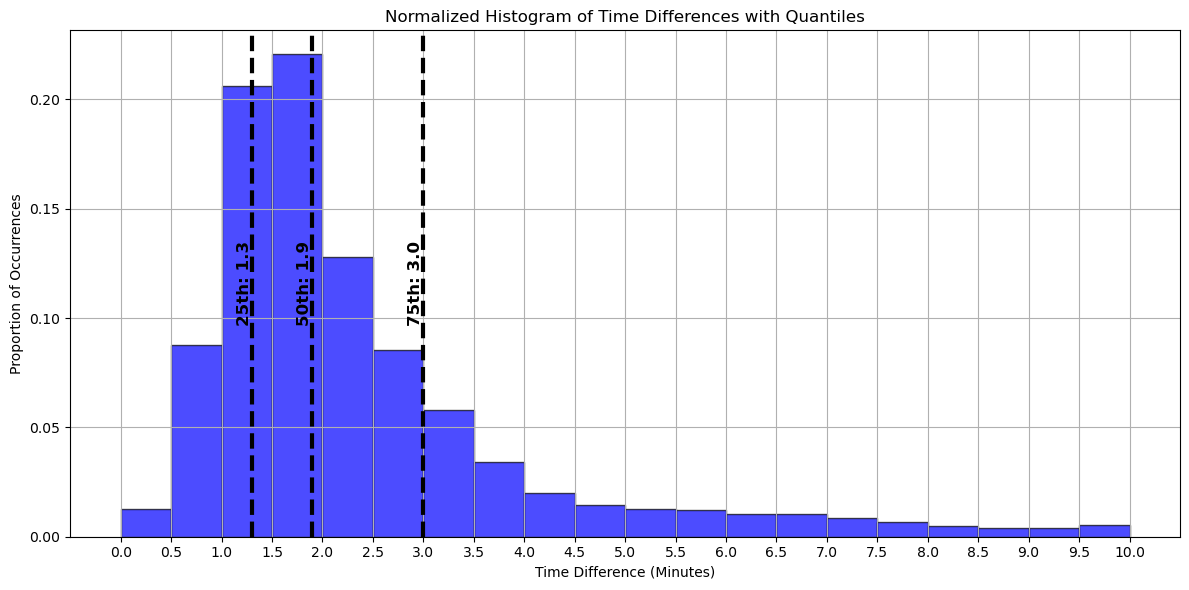

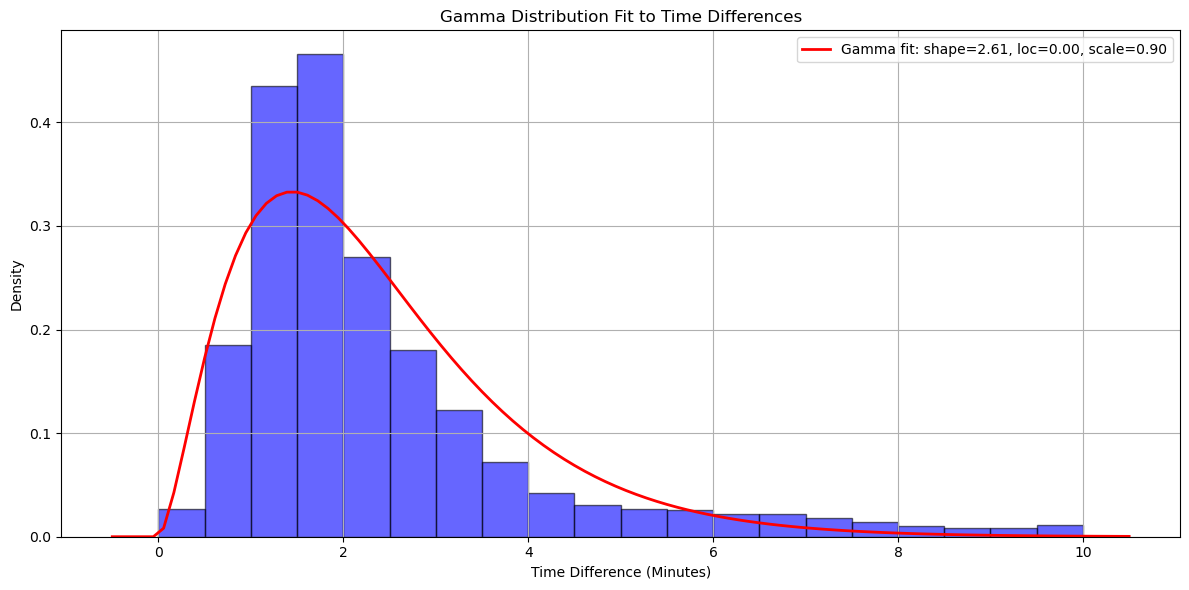

In [11]:
df = pd.DataFrame({'time_difference': all_time_differences})
total_values = len(df['time_difference'])

st = 0
end = 10
interval = 0.5
bin_edges = np.arange(st, end + interval, interval)

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(df['time_difference'], bins=bin_edges, color='b', edgecolor='black',
                                 alpha=0.7, weights=[1/total_values] * total_values)

plt.xticks(np.arange(st, end + interval, interval))

ymin, ymax = plt.ylim()
middle_height = (ymax - ymin) / 2

quantiles = df['time_difference'].quantile([0.25, 0.5, 0.75])

for quantile, value in quantiles.items():
    plt.axvline(x=value, color='k', linestyle='--', linewidth=3)  # Draw thick dashed line for each quantile
    plt.text(value, middle_height, f'{quantile*100:.0f}th: {value:.1f}', rotation=90, verticalalignment='center',
             horizontalalignment='right', color='k', fontsize=12, fontweight='bold')  # Position labels vertically at midpoint

plt.title('Normalized Histogram of Time Differences with Quantiles')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Proportion of Occurrences')

plt.grid(True)
plt.tight_layout()
plt.show()

filtered_data = df['time_difference'][(df['time_difference'] > 0) & (df['time_difference'] <= end)]

shape, loc, scale = stats.gamma.fit(filtered_data, floc=0.0001)

plt.figure(figsize=(12, 6))
plt.hist(df['time_difference'], bins=bin_edges, density=True, alpha=0.6, color='b', edgecolor='black')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pdf_fitted = stats.gamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf_fitted, 'r-', linewidth=2, label=f'Gamma fit: shape={shape:.2f}, loc={loc:.2f}, scale={scale:.2f}')

plt.title('Gamma Distribution Fit to Time Differences')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Density')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

**The histograms provided a clear picture of how often data was updated, showing whether the updates occurred regularly or at varied intervals.**

**To further refine the understanding of the data update frequency, a Gamma distribution was fitted to the time differences.**

**The frequency at which the data is updated was systematically approximated using a combination of time difference analysis, histogram visualization, and Gamma distribution fitting. The results show that the data is typically updated every 1.5 to 3 minutes, with a median of 1.9 minutes. It is recommended that API queries be made at 5-minute intervals to efficiently capture new data without overburdening the system.**

### Question 1.3
1. How many unique carparks are included in the carpark availability dataset?
2. Check if this value varies with time.
3. Explain why this check is important (about 20 words).

**For this task of identifying unique carparks over the month of July and observing if there are any new carparks added/ removed from the dataset, it is computationally heavy to track changes in number of carparks at every single data update.**

**Hence, we will instead be tracking the number of unique carpark numbers over 3 time intervals within the month of July 2024, the first interval will be tracking the number of carparks over an hour in intervals of 1 minute, the second tracking number of carparks over a day in hourly intervals and the last, tracking unique carparks over 12 days with daily intervals.**

**This will provide us various insights whereby, if there are changes in number of unique carparks over minute intervals, this might indicate a presence of perhaps update errors as such, similar to the hourly interval records. However, if there are changes to unique carpark numbers this could indicate possible new carparks being in operation or demolition of old carparks. As such changes in this value requires us to possibly re-evaluate and re-process the dataset.**

##### **Function for Data Extraction**

In [12]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)
    
    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            return data["items"][0]["carpark_data"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code}")
        return None

##### **Defining Helper Function to Get Unique Carparks**

In [13]:
def get_unique_carparks(timestamps):
    unique_carparks_over_time = {}
    for input_time in timestamps:
        print(f"Checking timestamp for: {input_time}")

        carpark_data = fetch_data_for_time(input_time.year, input_time.month, input_time.day,
                                           input_time.hour, input_time.minute, input_time.second)
        if carpark_data:
            carpark_numbers = {carpark["carpark_number"] for carpark in carpark_data if "carpark_number" in carpark}
            unique_carparks_over_time[input_time] = len(carpark_numbers)

        time.sleep(1)

    return pd.DataFrame(list(unique_carparks_over_time.items()), columns=['Timestamp', 'Unique_Carparks'])

##### **3 Differing Timestamps for 3 Different Time Intervals**

In [14]:
start_time_1h = datetime(2024, 7, 12, 10, 0, 0)
end_time_1h = datetime(2024, 7, 12, 11, 0, 0)
timestamps_1h = [start_time_1h + (end_time_1h - start_time_1h) * i / 11 for i in range(12)]

start_time_1d = datetime(2024, 7, 12, 10, 0, 0)
end_time_1d = datetime(2024, 7, 12, 22, 0, 0)
timestamps_1d = [start_time_1d + timedelta(hours=i) for i in range(12)]

start_date_12d = datetime(2024, 7, 12, 10, 0, 0)
end_date_12d = start_date_12d + timedelta(days=12)
timestamps_12d = [start_date_12d + (end_date_12d - start_date_12d) * i / 11 for i in range(12)]

##### **Fetching Data of Unique Carparks for 3 Time Intervals**

In [15]:
df_unique_carparks_1h = get_unique_carparks(timestamps_1h)
df_unique_carparks_1d = get_unique_carparks(timestamps_1d)
df_unique_carparks_12d = get_unique_carparks(timestamps_12d)

Checking timestamp for: 2024-07-12 10:00:00
Checking timestamp for: 2024-07-12 10:05:27.272727
Checking timestamp for: 2024-07-12 10:10:54.545455
Checking timestamp for: 2024-07-12 10:16:21.818182
Checking timestamp for: 2024-07-12 10:21:49.090909
Checking timestamp for: 2024-07-12 10:27:16.363636
Checking timestamp for: 2024-07-12 10:32:43.636364
Checking timestamp for: 2024-07-12 10:38:10.909091
Checking timestamp for: 2024-07-12 10:43:38.181818
Checking timestamp for: 2024-07-12 10:49:05.454545
Checking timestamp for: 2024-07-12 10:54:32.727273
Checking timestamp for: 2024-07-12 11:00:00
Checking timestamp for: 2024-07-12 10:00:00
Checking timestamp for: 2024-07-12 11:00:00
Checking timestamp for: 2024-07-12 12:00:00
Checking timestamp for: 2024-07-12 13:00:00
Checking timestamp for: 2024-07-12 14:00:00
Checking timestamp for: 2024-07-12 15:00:00
Checking timestamp for: 2024-07-12 16:00:00
Checking timestamp for: 2024-07-12 17:00:00
Checking timestamp for: 2024-07-12 18:00:00
Checki

##### **Plotting Number of Unique Carparks for 1 Hour (Minute Intervals)**

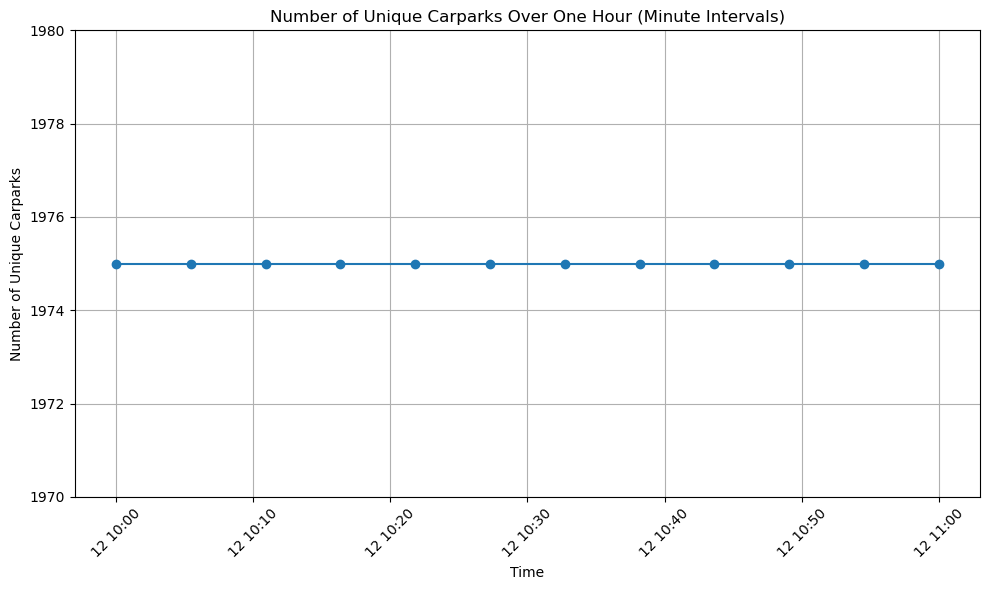

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_unique_carparks_1h['Timestamp'], df_unique_carparks_1h['Unique_Carparks'], marker='o')
plt.ylim(df_unique_carparks_1h['Unique_Carparks'].min() - 5, df_unique_carparks_1h['Unique_Carparks'].max() + 5)
plt.title('Number of Unique Carparks Over One Hour (Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Unique Carparks')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('unique_carparks_1_hour.png')  # Save plot for LaTeX reference
plt.show()

##### **Plotting Number of Unique Carparks for 1 Day (Hourly Intervals)**

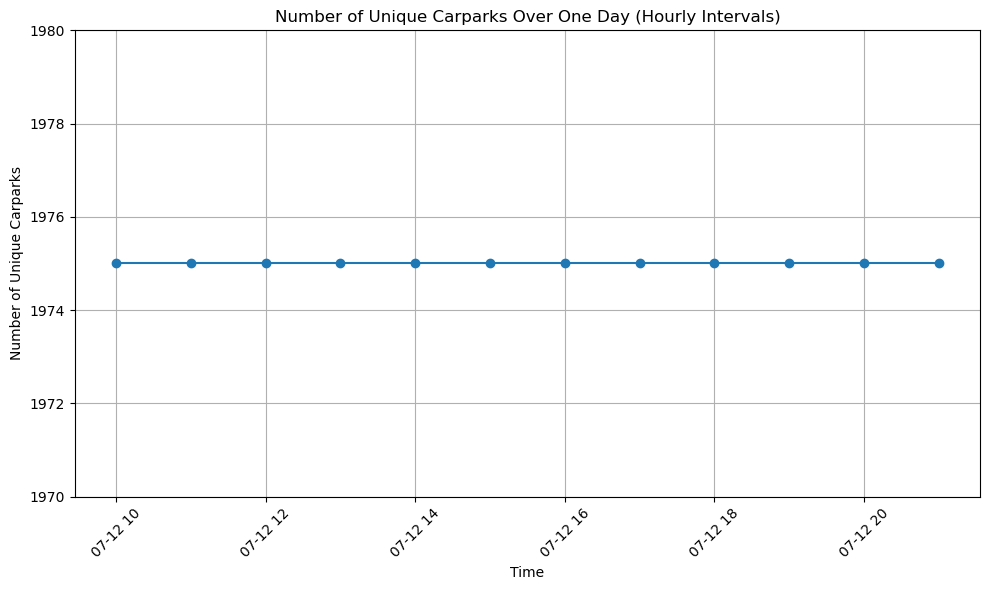

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_unique_carparks_1d['Timestamp'], df_unique_carparks_1d['Unique_Carparks'], marker='o')
plt.ylim(df_unique_carparks_1d['Unique_Carparks'].min() - 5, df_unique_carparks_1d['Unique_Carparks'].max() + 5)
plt.title('Number of Unique Carparks Over One Day (Hourly Intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Unique Carparks')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('unique_carparks_1_day.png')  # Save plot for LaTeX reference
plt.show()

##### **Plotting Number of Unique Carparks across 12 Days (Daily Intervals)**

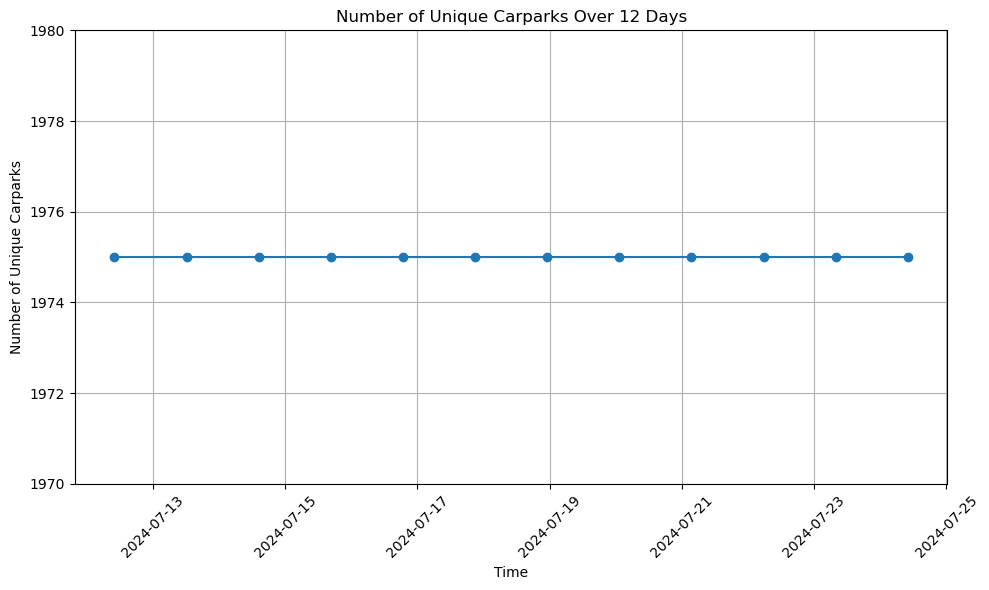

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_unique_carparks_12d['Timestamp'], df_unique_carparks_12d['Unique_Carparks'], marker='o')
plt.ylim(df_unique_carparks_12d['Unique_Carparks'].min() - 5, df_unique_carparks_12d['Unique_Carparks'].max() + 5)
plt.title('Number of Unique Carparks Over 12 Days')
plt.xlabel('Time')
plt.ylabel('Number of Unique Carparks')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('unique_carparks_12_days.png')  # Save plot for LaTeX reference
plt.show()

**Answer:**
1. There are 1975 unique carparks included in the dataset.
2. The number of unique carparks do not vary with time.
3. Variability in the number of unique carparks affects the overall data by perhaps introducing new factors that influences the overall trend of carpark availability. 

### Question 1.4
A carpark may have malfunctioning sensors. There are many types of possible malfunctions. Identify one of these carparks that you believe has a malfunctioning sensors. Explain what the “malfunction” is in this case (about 20 words)

**From the Dataset, there could be a presence of multiple malfunction errors. One such as having the number of available lots being more than the total number of lots in a carpark.**

**This could indicate that the sensor recording the number of cars leaving a carpark to be overly sensitive, tracking cars leaving when there are none.**

##### **Function for Data Extraction**

In [19]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            print(f"Data retrieved successfully for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["items"][0]["carpark_data"], data["items"][0]["timestamp"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None, None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code} for {year}-{month}-{day} {hour}:{minute}:{second}")
        return None, None

##### **Defining Helper Function for Identifying Malfunctions**

In [22]:
def find_malfunction(year, month, day, hour, min, sec):
    carpark_data, timestamp = fetch_data_for_time(year, month, day, hour, min, sec)  # Unpack the tuple
    if carpark_data is None:
        return 0

    carpark_trigger = []
    err_total_lots = []
    err_available_lots = []
    row_num = 0

    while row_num < len(carpark_data):
        row_status = carpark_data[row_num]  # Iterate over carpark_data

        total_lots_num = int(row_status['carpark_info'][0]['total_lots'])
        available_lots_num = int(row_status['carpark_info'][0]['lots_available'])
        carpark_num = row_status['carpark_number']

        if available_lots_num > total_lots_num:
            carpark_trigger.append(carpark_num)
            err_total_lots.append(total_lots_num)
            err_available_lots.append(available_lots_num)

        row_num += 1

    if carpark_trigger:
        print(f'Errors on: {year}-{month}-{day}T{hour}:{min}:{sec}')
        for i in range(len(carpark_trigger)):
            print(f'Carpark: {carpark_trigger[i]}, Total Lots: {err_total_lots[i]}, Available Lots: {err_available_lots[i]}')
    else:
       print(f'No Errors on {year}-{month}-{day}T{hour}:{min}:{sec}')

    return 1

##### **Tracking Carparks with Malfunction over a Specified Day**

In [23]:
for hour in range(1,25):
    boolean = find_malfunction(2024, 7, 1, hour, 0, 0)
    if boolean == 0:
        continue
    else:
         break

Data retrieved successfully for 2024-07-01 01:00:00
Errors on: 2024-7-1T1:0:0
Carpark: SK61, Total Lots: 10, Available Lots: 50


**Answer:**
This indicates that the malfunctioning sensor here is too senstive that it recorded 40 more cars leaving the carpark than the actual total lots.

### Question 1.5

Create a dataset of hourly carpark availability (i.e., for this project, use the ratio: lots available/total lots) from the raw data for the month of July 2024. Plot the average (average across all carparks) hourly carpark availability against time for that interval. Identify any patterns in the plot (about 50 words)

Note: You will have to decide what to do if there are no carpark readings for a certain hour. For example, some may impute the missing data or ignore it. You also have to decide if you want to (i) compute the ratios for each carpark and then average OR (ii) compute the total lots available and total total lots and take the ratios).

**For the month of July 2024, there are 31 days, therefore there would be a total of 744 hours. Acknowledging that there could be a presence of missing data for some of the hours, we have decided to remove those error points and interpolate the data based on the previous available lot data for that particular carpark.**

**For this question, we are choosing Option (ii) for computing the availability ratios for across all carparks.**

##### **Function for Data Extraction**

In [24]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            print(f"Data retrieved successfully for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["items"][0]["carpark_data"], data["items"][0]["timestamp"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None, None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code} for {year}-{month}-{day} {hour}:{minute}:{second}")
        return None, None

##### **Extracting Raw Lot Availability Ratio across July 2024 in Hourly Intervals & Saving Data in a JSON File**

In [25]:
start_date = datetime(2024, 7, 1, 0, 0, 0)
total_hours = 31 * 24

availability = []
timestamps = []

for hour in range(total_hours):
    current_time = start_date + timedelta(hours=hour)

    carpark_data, timestamp = fetch_data_for_time(
        current_time.year, current_time.month, current_time.day,
        current_time.hour, current_time.minute, current_time.second
    )

    if carpark_data is not None:
        total_lots = 0
        lots_available = 0
        for carpark in carpark_data:
            total_lots += int(carpark['carpark_info'][0]['total_lots'])
            lots_available += int(carpark['carpark_info'][0]['lots_available'])

        if total_lots > 0:
            availability.append(lots_available / total_lots)
        else:
            availability.append(None)
    else:
        availability.append(None)
        print(f"Missing data for {current_time.strftime('%Y-%m-%dT%H:%M:%S')}")

    timestamps.append(current_time.strftime("%Y-%m-%dT%H:%M:%S"))

df = pd.DataFrame({'date_time': timestamps, 'carpark_availability': availability})
raw_data = df.to_dict(orient="records")

with open("1.5_July_2024_raw_carpark_data.json", 'w') as fp:
    json.dump(raw_data, fp, indent=4)

print("Raw data saved to '1.5_July_2024_raw_carpark_data.json'")

No data available for 2024-07-01 00:00:00
Missing data for 2024-07-01T00:00:00
Data retrieved successfully for 2024-07-01 01:00:00
Data retrieved successfully for 2024-07-01 02:00:00
Data retrieved successfully for 2024-07-01 03:00:00
Data retrieved successfully for 2024-07-01 04:00:00
Data retrieved successfully for 2024-07-01 05:00:00
Data retrieved successfully for 2024-07-01 06:00:00
Data retrieved successfully for 2024-07-01 07:00:00
Data retrieved successfully for 2024-07-01 08:00:00
Data retrieved successfully for 2024-07-01 09:00:00
Data retrieved successfully for 2024-07-01 10:00:00
Data retrieved successfully for 2024-07-01 11:00:00
Data retrieved successfully for 2024-07-01 12:00:00
Data retrieved successfully for 2024-07-01 13:00:00
Data retrieved successfully for 2024-07-01 14:00:00
Data retrieved successfully for 2024-07-01 15:00:00
Data retrieved successfully for 2024-07-01 16:00:00
Data retrieved successfully for 2024-07-01 17:00:00
Data retrieved successfully for 2024-

##### **Interpolation on Raw Extracted Lot Availability Ratio Data**

In [26]:
with open("1.5_July_2024_raw_carpark_data.json", 'r') as fp:
    raw_data = json.load(fp)
df = pd.DataFrame(raw_data)

df['carpark_availability'] = df['carpark_availability'].ffill()

valid_indices = np.where(~df['carpark_availability'].isna())[0]
valid_values = df['carpark_availability'].dropna().values

cs = CubicSpline(valid_indices, valid_values)
all_indices = np.arange(len(df))
df['carpark_availability'] = cs(all_indices)

interpolated_data = df.to_dict(orient="records")

with open("1.5_July_2024_interpolated_carpark_data.json", 'w') as fp:
    json.dump(interpolated_data, fp, indent=4)

print("Interpolated data saved to '1.5_July_2024_interpolated_carpark_data.json'")

Interpolated data saved to '1.5_July_2024_interpolated_carpark_data.json'


##### **Data Visualisation on Lot Availability Ratio over July 2024 in Hourly Intervals**

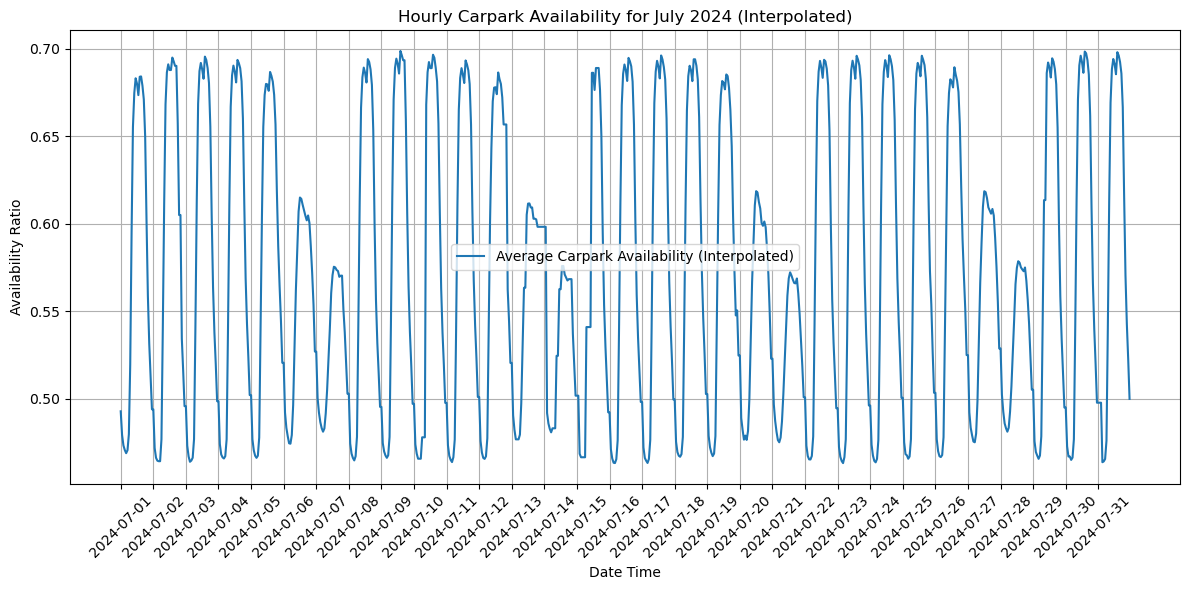

In [27]:
with open("1.5_July_2024_interpolated_carpark_data.json", 'r') as fp:
    interpolated_data = json.load(fp)

df = pd.DataFrame(interpolated_data)
df['date_time'] = pd.to_datetime(df['date_time'])

plt.figure(figsize=(12, 6))
plt.plot(df['date_time'], df['carpark_availability'], label="Average Carpark Availability (Interpolated)")
plt.xlabel("Date Time")
plt.ylabel("Availability Ratio")
plt.title("Hourly Carpark Availability for July 2024 (Interpolated)")
plt.grid(True)
plt.xticks(df['date_time'][::24], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Answer:**

The plot shows that carpark availability drops during the day, likely because more people are using it, and then goes up at night when demand is lower. There are some ups and downs over the month, possibly from weekends or special events. Overall, there’s a clear daily cycle, which could help predict carpark low lot availability times.

### Question 1.6

Intuitively, we expect that carpark availability across certain carparks to be correlated. For example, many housing carparks would experience higher carpark availability during working hours. Using the same interval chosen in 1.5. pick a carpark find the carpark that is the most correlated to it (in terms of carpark availability). State the type of correlation used (e.g. Spearman, Pearson, etc.)

##### **Function for Data Extraction**

In [38]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            print(f"Data retrieved successfully for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["items"][0]["carpark_data"], data["items"][0]["timestamp"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None, None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code} for {year}-{month}-{day} {hour}:{minute}:{second}")
        return None, None

##### **Extracting Raw Lot Availability Ratio Data for Each Unique Carparks & Saving Data in JSON File**

In [40]:
start_date = datetime(2024, 7, 1, 0, 0, 0)
total_hours = 31 * 24
availability_data = {}

for hour in range(total_hours):
    current_time = start_date + timedelta(hours=hour)

    carpark_data, timestamp = fetch_data_for_time(
        current_time.year, current_time.month, current_time.day,
        current_time.hour, current_time.minute, current_time.second
    )

    if carpark_data is not None:
        for carpark in carpark_data:
            carpark_number = carpark['carpark_number']
            total_lots = int(carpark['carpark_info'][0]['total_lots'])
            lots_available = int(carpark['carpark_info'][0]['lots_available'])

            if total_lots > 0:
                availability_ratio = lots_available / total_lots
            else:
                availability_ratio = None

            if carpark_number not in availability_data:
                availability_data[carpark_number] = []
            availability_data[carpark_number].append((hour, availability_ratio))
    else:
        print(f"No data for {current_time}")

with open("1.6_carpark_hourly_availability_data.json", 'w') as fp:
    json.dump(availability_data, fp, indent=4)

print("Hourly availability data saved to '1.6_carpark_hourly_availability_data.json'")

No data available for 2024-07-01 00:00:00
No data for 2024-07-01 00:00:00
Data retrieved successfully for 2024-07-01 01:00:00
Data retrieved successfully for 2024-07-01 02:00:00
Data retrieved successfully for 2024-07-01 03:00:00
Data retrieved successfully for 2024-07-01 04:00:00
Data retrieved successfully for 2024-07-01 05:00:00
Data retrieved successfully for 2024-07-01 06:00:00
Data retrieved successfully for 2024-07-01 07:00:00
Data retrieved successfully for 2024-07-01 08:00:00
Failed to fetch data. Status code: 500 for 2024-07-01 09:00:00
No data for 2024-07-01 09:00:00
Data retrieved successfully for 2024-07-01 10:00:00
Failed to fetch data. Status code: 500 for 2024-07-01 11:00:00
No data for 2024-07-01 11:00:00
Failed to fetch data. Status code: 504 for 2024-07-01 12:00:00
No data for 2024-07-01 12:00:00
Data retrieved successfully for 2024-07-01 13:00:00
Data retrieved successfully for 2024-07-01 14:00:00
Data retrieved successfully for 2024-07-01 15:00:00
Data retrieved su

##### **Interpolation on Raw Lot Availability Ratio for Each Unique Carpark**

In [57]:
with open("1.6_carpark_hourly_availability_data.json", 'r') as fp:
    availability_data = json.load(fp)

carpark_dataframes = []

for carpark, data in availability_data.items():
    formatted_data = [{"hour": entry[0], "availability_ratio": entry[1]} for entry in data]
    df_temp = pd.DataFrame(formatted_data).drop_duplicates(subset="hour").set_index("hour")
    carpark_dataframes.append(df_temp.rename(columns={"availability_ratio": carpark}))

availability_df = pd.concat(carpark_dataframes, axis=1)

availability_df.ffill(inplace=True)

interpolated_data = [
    {"hour": hour, "carpark_number": carpark, "availability_ratio": availability_df.at[hour, carpark]}
    for carpark in availability_df.columns
    for hour in availability_df.index
    if pd.notna(availability_df.at[hour, carpark])
]

with open("1.6_interpolated_carpark_availability_data.json", 'w') as fp:
    json.dump(interpolated_data, fp, indent=4)

print("Interpolated data saved to '1.6_interpolated_carpark_availability_data.json'")

Interpolated data saved to '1.6_interpolated_carpark_availability_data.json'


##### **Generating a Unique Carpark for Correlation Analysis**

In [58]:
initial_data = None

while initial_data == None:
    random_day = random.randint(1,31)
    random_hour = random.randint(1,24)
    initial_data, _ = fetch_data_for_time(2024, 7, random_day, random_hour, 0, 0)
    if initial_data == None:
        print(f"Failed to fetch capark data on 2024-7-{random_day} {random_hour}:00:00.")

carpark_numbers = [carpark['carpark_number'] for carpark in initial_data]
chosen_carpark = random.choice(carpark_numbers)
print(f"Chosen carpark for correlation analysis: {chosen_carpark}")

Data retrieved successfully for 2024-07-18 14:00:00
Chosen carpark for correlation analysis: T30


In [51]:
chosen_carpark = 'T16'

##### **Correlation Analysis on Both Pearson & Spearman Correlation**

In [61]:
with open("1.6_interpolated_carpark_availability_data.json", 'r') as fp:
    interpolated_data = json.load(fp)

interpolated_df = pd.DataFrame(interpolated_data)
availability_df = interpolated_df.pivot(index="hour", columns="carpark_number", values="availability_ratio")

chosen_data = availability_df[chosen_carpark].dropna()
h_chosen = chosen_data.index.tolist()
ratio_chosen = chosen_data.values.tolist()

max_positive_pearson = -1
max_negative_pearson = 1
best_positive_pearson = None
best_negative_pearson = None

max_positive_spearman = -1
max_negative_spearman = 1
best_positive_spearman = None
best_negative_spearman = None

for carpark in availability_df.columns:
    if carpark != chosen_carpark:
        other_data = availability_df[carpark].dropna()
        h_other = other_data.index.tolist()
        ratio_other = other_data.values.tolist()

        common_hours = list(set(h_chosen) & set(h_other))
        chosen_common_ratios = [ratio_chosen[h_chosen.index(hour)] for hour in common_hours]
        other_common_ratios = [ratio_other[h_other.index(hour)] for hour in common_hours]

        if len(common_hours) > 2 and len(set(chosen_common_ratios)) > 1 and len(set(other_common_ratios)) > 1:

            pearson_corr, _ = pearsonr(chosen_common_ratios, other_common_ratios)
            if pearson_corr > max_positive_pearson:
                max_positive_pearson = pearson_corr
                best_positive_pearson = carpark
            if pearson_corr < max_negative_pearson:
                max_negative_pearson = pearson_corr
                best_negative_pearson = carpark

            spearman_corr, _ = spearmanr(chosen_common_ratios, other_common_ratios)
            if spearman_corr > max_positive_spearman:
                max_positive_spearman = spearman_corr
                best_positive_spearman = carpark
            if spearman_corr < max_negative_spearman:
                max_negative_spearman = spearman_corr
                best_negative_spearman = carpark

##### **Data Visualisation on Pearson Correlation Analysis**

Most positively Pearson-correlated carpark to T30: U13 with correlation 0.9502670110407387
Most negatively Pearson-correlated carpark to T30: BH1 with correlation -0.9133412196685029


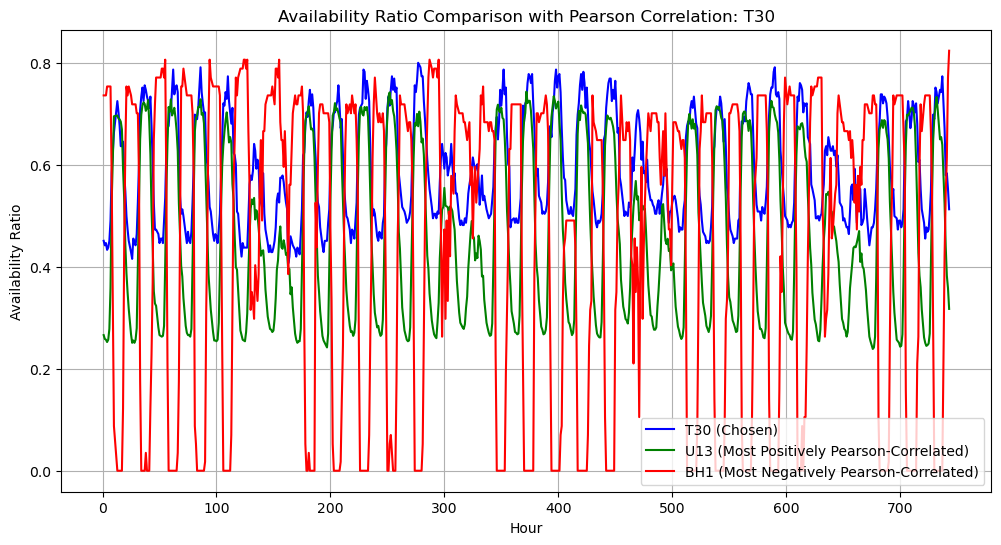

In [62]:
print(f'Most positively Pearson-correlated carpark to {chosen_carpark}: {best_positive_pearson} with correlation {max_positive_pearson}')
print(f'Most negatively Pearson-correlated carpark to {chosen_carpark}: {best_negative_pearson} with correlation {max_negative_pearson}')

plt.figure(figsize=(12, 6))
plt.plot(availability_df.index, availability_df[chosen_carpark], label=f"{chosen_carpark} (Chosen)", color="blue")
if best_positive_pearson:
    plt.plot(availability_df.index, availability_df[best_positive_pearson], label=f"{best_positive_pearson} (Most Positively Pearson-Correlated)", color="green")
if best_negative_pearson:
    plt.plot(availability_df.index, availability_df[best_negative_pearson], label=f"{best_negative_pearson} (Most Negatively Pearson-Correlated)", color="red")

plt.xlabel("Hour")
plt.ylabel("Availability Ratio")
plt.title(f"Availability Ratio Comparison with Pearson Correlation: {chosen_carpark}")
plt.legend()
plt.grid(True)
plt.show()


##### **Data Visualisation on Spearman Correlation Analysis**

Most positively Spearman-correlated carpark to T30: BJ50 with correlation 0.9413963064950364
Most negatively Spearman-correlated carpark to T30: BH2 with correlation -0.8810008498354512


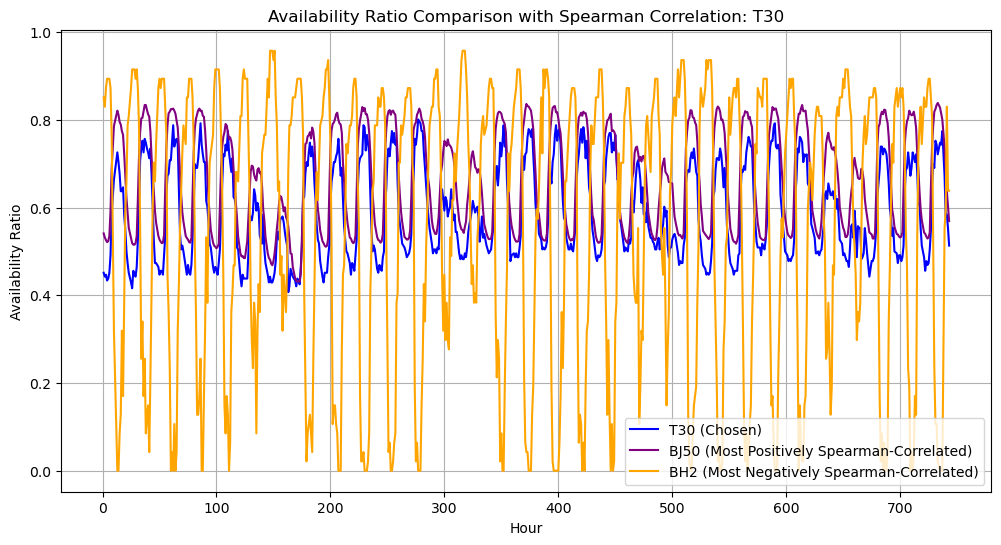

In [63]:
print(f'Most positively Spearman-correlated carpark to {chosen_carpark}: {best_positive_spearman} with correlation {max_positive_spearman}')
print(f'Most negatively Spearman-correlated carpark to {chosen_carpark}: {best_negative_spearman} with correlation {max_negative_spearman}')


plt.figure(figsize=(12, 6))
plt.plot(availability_df.index, availability_df[chosen_carpark], label=f"{chosen_carpark} (Chosen)", color="blue")
if best_positive_spearman:
    plt.plot(availability_df.index, availability_df[best_positive_spearman], label=f"{best_positive_spearman} (Most Positively Spearman-Correlated)", color="purple")
if best_negative_spearman:
    plt.plot(availability_df.index, availability_df[best_negative_spearman], label=f"{best_negative_spearman} (Most Negatively Spearman-Correlated)", color="orange")

plt.xlabel("Hour")
plt.ylabel("Availability Ratio")
plt.title(f"Availability Ratio Comparison with Spearman Correlation: {chosen_carpark}")
plt.legend()
plt.grid(True)
plt.show()

### Question 1.7

Group Project Proposal for Question 3: Please include a short proposal (around 500 words) of what your team intends to do for the Group Proposed Project in
Question 3. For the group project proposal, you may use additional datasets to supplement your analysis or look at unaggregated data, etc. See Question 3 below for more information about this. Please use markdown in the iPython notebook to present your proposal.

### Objective
To analyze and predict carpark occupancy across Singapore using environmental, traffic, and public transport data. The project aims to identify patterns in carpark demand based on external factors like weather, traffic congestion, and public transport usage. Insights from this analysis will help inform carpark management decisions, improve traffic flow, and potentially support dynamic pricing strategies.

### Dataset Requirements
1. Carpark Availability: Real-time and historical data on carpark occupancy across Singapore, including fields such as carpark_number, update_datetime, total_lots, lot_type, and lots_available.
2. Rainfall Data: Provides hourly or five-minute rainfall readings across various locations in Singapore. This dataset will help correlate weather conditions with carpark demand.
3. Traffic Flow Data: Hourly average traffic flow data for key roads across Singapore, capturing levels of congestion that may influence private vehicle usage and carpark occupancy.
4. Passenger Volume by Bus Stops or Train Stations: Data on public transport usage, focusing on passenger volume by origin-destination at bus stops or train stations. This data helps assess the impact of public transport availability on carpark demand.

### Data Collection Methods
1. API Access: We will use the data.gov.sg API to pull data for carpark availability, rainfall, and traffic flow at regular intervals.
2. Historical Data Retrieval: For analyzing trends, we will gather historical data for carpark availability, weather conditions, and traffic flow over a specific timeframe (e.g., the last 6–12 months).
3. Data Merging: The datasets will be aligned by timestamp to create a unified dataset, allowing for a comprehensive analysis of how external factors influence carpark demand.

### Data Preparation and Processing
To ensure the model’s reliability and robustness, we will carry out comprehensive data preparation, covering:

1. **Outlier Handling**: We will inspect unusual patterns, such as high occupancy during adverse weather or non-peak hours, to identify and manage any outliers that might affect model accuracy. For example, there might a big event near the investigated car parks.

2. **Managing Missing Values**: Missing data points, will be handled. Interpolation is implemented for reasonably long intervals of missing data. Data will be discarded if it is not useful for our prediction.

3. **Duplicate Removal**: We will identify and remove redundant data entries, as duplicates can introduce artificial correlations that misrepresent the underlying data patterns. Removing duplicates ensures that each observation has an appropriate impact on the model, reducing the risk of bias and improving model accuracy.

4. **Feature Selection**: We will use Lasso Regression and statistical significance testing to select the most relevant features. Lasso’s regularization will help eliminate less impactful predictors, while statistical tests will ensure we retain only the features with strong predictive power, enhancing model accuracy and interpretability.

### Model Prediction

Our approach for model prediction includes:

1. **Data Splitting**: We will divide the data into training and testing sets, using them to train and evaluate the model’s generalization capability.

2. **Model Selection**: To identify the best-performing model, we will implement the following models.   
   - **Gradient Boosting Regressor (GBR)**: This model can capture non-linear relationships between occupancy and features like weather by utilizing ensemble learning.
   - **LSTM**: An LSTM recurrent neural network will help capture long-term temporal dependencies and patterns in occupancy data.
   - **ARIMA**: ARIMA will be used to model seasonality and trends.
   

3. **Parameter Tuning**: Each model will undergo cross-validation with GridSearch for parameter optimization on the validation set. This approach will ensure that each model is thoroughly evaluated and tuned to deliver reliable and robust predictions.

4. **Feature Engineering**: We will introduce new features and apply simple transformations to enhance model clarity and capture key trends effectively. For instance, grouping days into categories like "weekend" (Saturday and Sunday) and "weekday" (Monday through Friday) may help the models better identify occupancy patterns associated with different day types.

### Model Evaluation

To ensure reliable and accurate predictions, we will evaluate model performance using the following methods:

1. **Performance Metrics**: Since this is a regression problem, we will use metrics like Mean Absolute Error (MAE) and Mean Squared Error (MSE) to evaluate prediction accuracy.

2. **Test set performance**: After all hyper parameters have been tuned. Every models' performance will finally be tested on unseen data (test set). The best one will be used.


### Conclusion
Our analysis and predictions will provide insights into how external factors such as weather, traffic, and public transport usage influence carpark demand. These findings will help carpark operators make data-driven decisions, potentially implementing dynamic pricing strategies or adjusting resource allocation based on anticipated demand. The project outcomes could also guide city planners in improving traffic flow and public transport integration around high-demand carparks, contributing to a more efficient urban infrastructure.